# Library

In [65]:
import os
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Flatten, MaxPooling2D, Conv2D, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import scipy
from PIL import Image
import warnings
warnings.catch_warnings
import cv2 as cv
from scipy import stats
from tqdm import tqdm
import shutil
import time

# Load Dataset (Melanoma)

In [66]:
# # Importing required libraries
# import kagglehub

# # Downloading the dataset
# path = kagglehub.dataset_download("drscarlat/melanoma")
# print("Path to dataset files:", path)

# # Moving dataset to the current directory
# destination_dir = '.'  # Current directory

# for item in os.listdir(path):
#     source_path = os.path.join(path, item)
#     destination_path = os.path.join(destination_dir, item)

#     if os.path.isfile(source_path):
#         shutil.move(source_path, destination_path)
#     elif os.path.isdir(source_path):
#         shutil.move(source_path, destination_path)

# print("Dataset files moved to the current directory.")

# Dataset

In [67]:
# Basic config
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10

In [68]:
train_path = './dermmel/DermMel/train_sep'
val_path = './dermmel/DermMel/valid'
test_path = './dermmel/DermMel/test'

In [69]:
# Melihat jumlah total dataset dan pembagian kelasnya
def count_dataset(path):
  class_counts = {}
  total_count = 0
  for root, dirs, files in os.walk(path):
    for file in files:
      class_name = os.path.basename(root)
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1
      total_count += 1
  return total_count, class_counts


train_total, train_class_counts = count_dataset(train_path)
val_total, val_class_counts = count_dataset(val_path)
test_total, test_class_counts = count_dataset(test_path)

print("Train Dataset:")
print("Total images:", train_total)
print("Class counts:", train_class_counts)

print("\nValidation Dataset:")
print("Total images:", val_total)
print("Class counts:", val_class_counts)

print("\nTest Dataset:")
print("Total images:", test_total)
print("Class counts:", test_class_counts)

Train Dataset:
Total images: 10682
Class counts: {'NotMelanoma': 5341, 'Melanoma': 5341}

Validation Dataset:
Total images: 3562
Class counts: {'NotMelanoma': 1781, 'Melanoma': 1781}

Test Dataset:
Total images: 3561
Class counts: {'NotMelanoma': 1780, 'Melanoma': 1781}


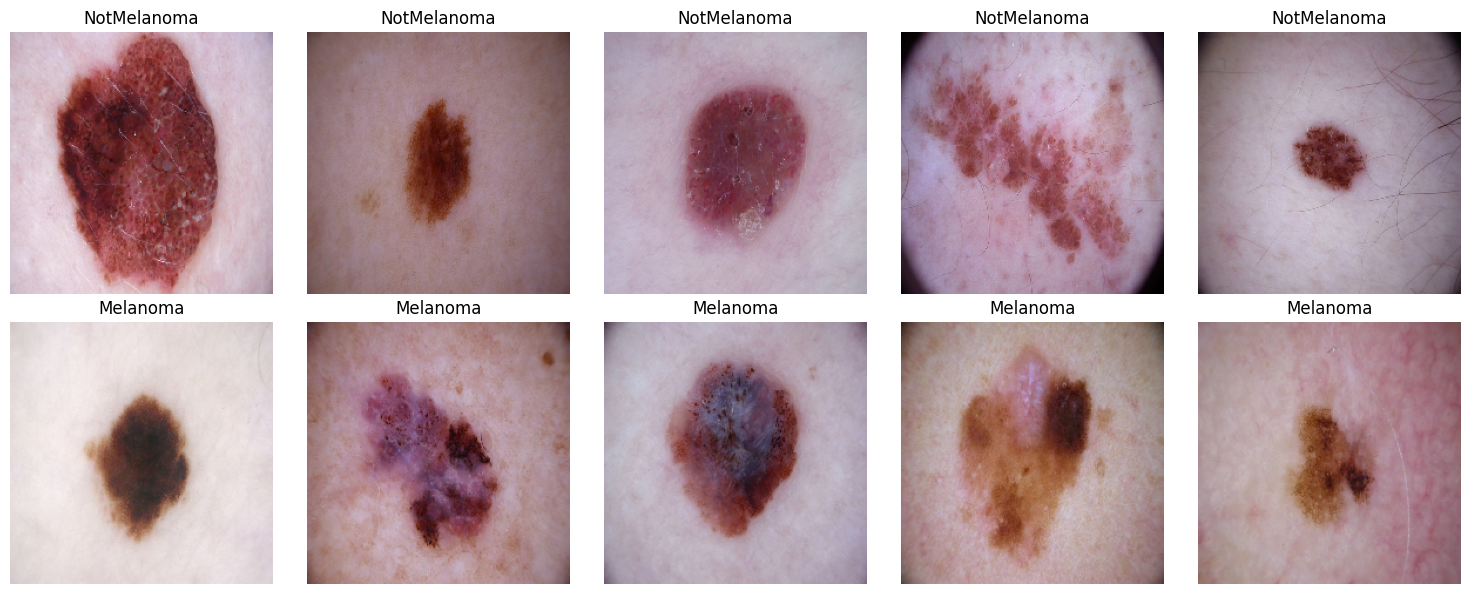

In [70]:
# Melihat sample data
def display_image(dir, num_img=5):
    categories = os.listdir(dir)
    categories = [category for category in categories if category != '.DS_Store']
    fig, ax = plt.subplots(len(categories), num_img, figsize=(num_img*3, len(categories)*3))

    for i, category in enumerate(categories):
        category_dir = os.path.join(dir, category)
        images = os.listdir(category_dir)[:num_img]

        for j, image in enumerate(images):
            img_path = os.path.join(category_dir, image)
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

            ax[i,j].imshow(img)
            ax[i,j].set_title(category)
            ax[i,j].axis('off')

    plt.tight_layout()
    plt.show()

display_image(train_path)

In [71]:
classes = ['Melanoma', 'NotMelanoma']
classes

['Melanoma', 'NotMelanoma']

# Default (No Hair Removal)

In [72]:
# ImageDataGenerators
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb'
)

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False
)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [73]:
class CustomF1Score(F1Score):
    def __init__(self, name="f1_score", dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to binary based on a 0.5 threshold
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        # Calculate true positives, false positives, and false negatives
        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum(y_pred * (1 - y_true))
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        # Update the state variables
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [74]:
def evaluate_model(model, test_generator, classes, threshold=0.5):
    # Predict labels for the test data
    y_pred = model.predict(test_generator)
    # Binarize predictions based on threshold
    y_pred = (y_pred > threshold).astype(int)
    # Get true labels from the test generator
    y_true = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Display classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [75]:
def plot_training_history(history):
    """
    Menampilkan plot akurasi dan loss untuk training dan validation selama epoch dengan rentang y-axis dari 0 hingga 1
    dengan interval 0.1.
    
    Parameter:
    - history: Objek history yang dikembalikan oleh metode fit model.
    """
    plt.figure(figsize=(12, 4))

    # Definisikan ticks dari 0 hingga 1 dengan interval 0.1
    y_ticks = np.arange(0, 1.1, 0.1)

    # Plot akurasi training dan validation
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Akurasi Training')
    plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)            # Mengatur rentang y-axis dari 0 hingga 1
    plt.yticks(y_ticks)       # Mengatur ticks y-axis dengan interval 0.1
    plt.legend()

    # Plot loss training dan validation
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Training')
    plt.plot(history.history['val_loss'], label='Loss Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 1)            # Mengatur rentang y-axis dari 0 hingga 1
    plt.yticks(y_ticks)       # Mengatur ticks y-axis dengan interval 0.1
    plt.legend()

    plt.tight_layout()
    plt.show()

In [76]:
import pandas as pd

def save_training_history(history, filename):
    """Saves training history to a CSV file with the model name.

    Args:
        history: The training history object returned by model.fit().
        filename: The name of the CSV file to save the history to.
        model_name: The name of the model (string) to include in the CSV file.
    """
    results_df = pd.DataFrame(history.history)
    results_df.insert(0, 'epoch', range(1, len(results_df) + 1))  # Menambahkan kolom 'epoch'
    results_df.to_csv(filename, index=False)

## Standart

In [77]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [78]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam()

In [79]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_baseline = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [80]:
model_baseline.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_baseline.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_4  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 1024)              984064    
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)              

In [81]:
mcp = ModelCheckpoint('model_baseline.h5', save_best_only = True)

In [82]:
start_time = time.time()

history = model_baseline.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1,
    callbacks=[lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / EPOCHS 

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.9334 - precision: 0.8987 - recall: 0.9771 - f1_score: 0.9362

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 76s 194ms/step - loss: 0.8718 - accuracy: 0.9334 - precision: 0.8987 - recall: 0.9771 - f1_score: 0.9362 - val_loss: 0.8288 - val_accuracy: 0.8891 - val_precision: 0.9464 - val_recall: 0.8249 - val_f1_score: 0.8815 - lr: 0.0010
Epoch 2/10
333/333 [==============================] - 52s 157ms/step - loss: 0.2313 - accuracy: 0.9437 - precision: 0.9097 - recall: 0.9852 - f1_score: 0.9459 - val_loss: 1.2890 - val_accuracy: 0.8336 - val_precision: 0.7504 - val_recall: 0.9994 - val_f1_score: 0.8572 - lr: 0.0010
Epoch 3/10
333/333 [==============================] - 49s 147ms/step - loss: 0.1467 - accuracy: 0.9506 - precision: 0.9288 - recall: 0.9759 - f1_score: 0.9518 - val_loss: 0.2867 - val_accuracy: 0.9445 - val_precision: 0.9135 - val_recall: 0.9820 - val_f1_score: 0.9465 - lr: 0.0010
Epoch 4/10
333/333 [==============================] - 51s 152ms/step - loss: 0.1121 - accuracy: 0.9589 - precision: 0.9479 - recall: 0.9711 - f1_score: 0.9594 - val_

In [83]:
start_inf_time = time.time()

test_result_baseline = model_baseline.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_baseline

end_inf_time = time.time()

inference_time = end_inf_time - start_inf_time

test_result_baseline["training_time"] = total_training_time
test_result_baseline["avg_training_time"] = average_time_per_epoch
test_result_baseline["inference_time"] = inference_time

112/112 [==============================] - 21s 192ms/step - loss: 25.2271 - accuracy: 0.6787 - precision: 0.6094 - recall: 0.9955 - f1_score: 0.7560


112/112 [==============================] - 12s 101ms/step
Confusion Matrix:
[[ 645 1136]
 [   8 1772]]


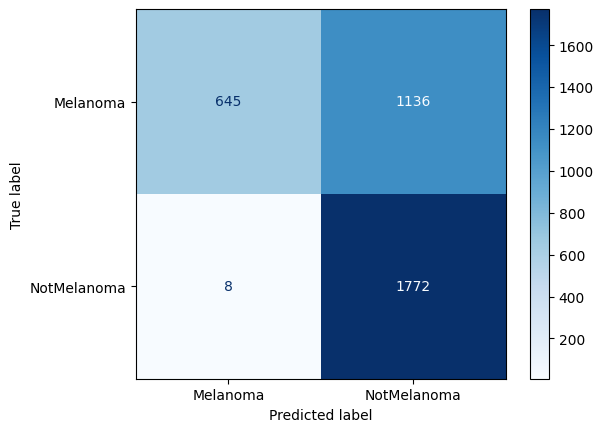

Classification Report:
              precision    recall  f1-score   support

    Melanoma     0.9877    0.3622    0.5300      1781
 NotMelanoma     0.6094    0.9955    0.7560      1780

    accuracy                         0.6787      3561
   macro avg     0.7986    0.6788    0.6430      3561
weighted avg     0.7986    0.6787    0.6430      3561



In [84]:
evaluate_model(model_baseline, test_generator, classes)

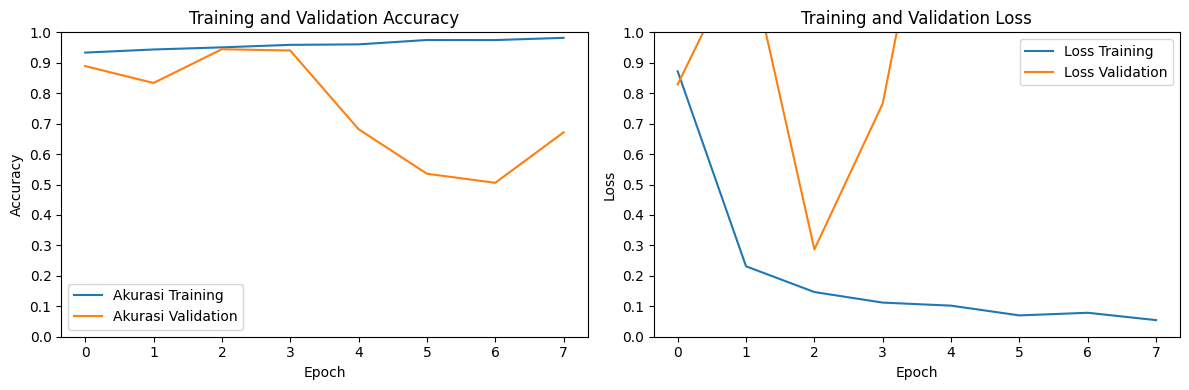

In [85]:
plot_training_history(history)

In [86]:
save_training_history(history, 'model_baseline_train_val_results.csv')

In [87]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [88]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)

In [89]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_default_aug = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [90]:
model_default_aug.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_default_aug.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_5  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              984064    
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)              

In [91]:
mcp = ModelCheckpoint('model_default_aug.h5', save_best_only = True)

In [92]:
start_time = time.time()

history = model_default_aug.fit(
    train_generator_aug,
    epochs = EPOCHS,
    validation_data = validation_generator,
    steps_per_epoch = train_generator_aug.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / EPOCHS 

NameError: name 'train_generator_aug' is not defined

In [ ]:
start_inf_time = time.time()

test_result_no_dhr_aug = model_default_aug.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_no_dhr_aug

end_inf_time = time.time()

inference_time = end_inf_time - start_inf_time

test_result_no_dhr_aug["training_time"] = total_training_time
test_result_no_dhr_aug["avg_training_time"] = average_time_per_epoch
test_result_no_dhr_aug["inference_time"] = inference_time

In [ ]:
evaluate_model(model_default_aug, test_generator, classes)

In [ ]:
plot_training_history(history)

In [ ]:
save_training_history(history, 'model_default_aug_train_val_results.csv')

In [ ]:
import cv2
import numpy as np

def dull_razor_hair_removal(img):
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply blackhat filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)

    # 0=skin, 255=hair
    lowbound = 12
    _, mask = cv2.threshold(blackhat, lowbound, 255, cv2.THRESH_BINARY)

    # Inpaint to remove hair
    inpaint_radius = 3
    img_final = cv2.inpaint(img, mask, inpaint_radius, cv2.INPAINT_TELEA)

    return img_final

In [ ]:
# Load the images for sample
image_paths = [
    '/workspace/dermmel/DermMel/train_sep/Melanoma/AUG_0_2471.jpeg',
    '/workspace/dermmel/DermMel/train_sep/Melanoma/AUG_0_1780.jpeg',
    '/workspace/dermmel/DermMel/train_sep/Melanoma/AUG_0_157.jpeg',
    '/workspace/dermmel/DermMel/train_sep/Melanoma/AUG_0_1709.jpeg',
    '/workspace/dermmel/DermMel/train_sep/Melanoma/AUG_0_1734.jpeg',
]

# Process images and store results
original_img = []
processed_images = []

for path in image_paths:
    img = cv2.imread(path)
    original_img.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    processed_images.append(dull_razor_hair_removal(img))

# Display images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(5):
    # baris pertama: original image
    axes[0, i].imshow(original_img[i])
    axes[0, i].axis('off')
    axes[0, i].set_title("Original Image")

    # baris kedua: processed (hair removed) image
    axes[1, i].imshow(cv2.cvtColor(processed_images[i], cv2.COLOR_BGR2RGB))
    axes[1, i].axis('off')
    axes[1, i].set_title("Hair Removed Image")

plt.tight_layout()
plt.show()

In [ ]:
# path asal (data latih)
input_dir = train_path
# path tujuan (hasil setelah dullrazor)
output_dir = "/workspace/Hair Removed Images 2"

# Cek apakah train_output_path sudah ada, kalau belum buat folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop keseluruhan subfolder dan file
for root, dirs, files in os.walk(input_dir):
    # Tentukan relatif path terhadap train_path
    relative_path = os.path.relpath(root, input_dir)
    # Tentukan folder output yang sesuai
    output_folder = os.path.join(output_dir, relative_path)

    # Jika folder output belum ada, buat folder tersebut
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in files:
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            input_path = os.path.join(root, filename)
            output_path = os.path.join(output_folder, filename)

            # Baca gambar
            image = cv2.imread(input_path)
            if image is None:
                print(f"Gagal membaca: {input_path}")
                continue

            # Jalankan dullrazor
            processed_image = dull_razor_hair_removal(image)

            # Simpan hasil ke folder output
            cv2.imwrite(output_path, processed_image)

print(f"Berhasil memproses dan menyimpan: {output_path}")

In [ ]:
dhr_train_path = '/workspace/Hair Removed Images 2'

In [ ]:
dhr_train_total, dhr_train_class_counts = count_dataset(dhr_train_path)

print("Hair Removed Images Count:")
print("Total images:", dhr_train_total)
print("Class counts:", dhr_train_class_counts)

In [ ]:
display_image(dhr_train_path)

In [ ]:
train_datagen_hair_removal_aug = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    )

train_datagen_hair_removal_std = ImageDataGenerator()

# Generators
train_generator_dhr_aug = train_datagen_hair_removal_aug.flow_from_directory(
    dhr_train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

train_generator_dhr_std = train_datagen_hair_removal_std.flow_from_directory(
    dhr_train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

## Standart



In [ ]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [ ]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)

In [ ]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_dhr_std = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
model_dhr_std.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_dhr_std.summary()

In [ ]:
mcp = ModelCheckpoint('model_dhr_std.h5', save_best_only = True)

In [ ]:
start_time = time.time()

history = model_dhr_std.fit(
    train_generator_dhr_std,
    epochs = EPOCHS,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / EPOCHS 

In [ ]:
start_inf_time = time.time()

test_result_dhr_std = model_dhr_std.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_dhr_std

end_inf_time = time.time()

inference_time = end_inf_time - start_inf_time

test_result_dhr_std["training_time"] = total_training_time
test_result_dhr_std["avg_training_time"] = average_time_per_epoch
test_result_dhr_std["inference_time"] = inference_time

In [ ]:
evaluate_model(model_dhr_std, test_generator, classes)

In [ ]:
plot_training_history(history)

In [ ]:
save_training_history(history, 'model_dhr_std_train_val_results.csv')

## Augmentation

In [ ]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [ ]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)

In [ ]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_dhr_aug = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
model_dhr_aug.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_dhr_aug.summary()

In [ ]:
mcp = ModelCheckpoint('model_dhr_aug.h5', save_best_only = True)

In [ ]:
start_time = time.time()

history = model_dhr_aug.fit(
    train_generator_dhr_aug,
    epochs = EPOCHS,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / EPOCHS

In [ ]:
start_inf_time = time.time()

test_result_dhr_aug = model_dhr_aug.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_dhr_aug

end_inf_time = time.time()

inference_time = end_inf_time - start_inf_time

test_result_dhr_aug["training_time"] = total_training_time
test_result_dhr_aug["avg_training_time"] = average_time_per_epoch
test_result_dhr_aug["inference_time"] = inference_time

In [ ]:
evaluate_model(model_dhr_aug, test_generator, classes)

In [ ]:
plot_training_history(history)

In [ ]:
save_training_history(history, 'model_dhr_aug_train_val_results.csv')

# Results Table

In [93]:
import pandas as pd

def save_test_results_to_csv(results_dict, filename):
    """
    Saves the results of model testing to a CSV file.
    Args:
        results_dict (dict): 
            Dictionary dengan key = nama model (string) 
            dan value = dictionary metrik evaluasi (loss, acc, dsb).
        filename (str): 
            Nama file CSV.
    """
    df = pd.DataFrame.from_dict(results_dict, orient='index')
    df.index.name = "Skenario"
    df.reset_index(inplace=True)
    df.to_csv(filename, index=False)

test_results = {
    "model_baseline": test_result_baseline,
}

save_test_results_to_csv(test_results, "model_baseline_test_results.csv")
pd.read_csv('model_baseline_test_results.csv')

,Skenario,loss,accuracy,precision,recall,f1_score,training_time,avg_training_time,inference_time
0,model_baseline,25.227089,0.678742,0.609353,0.995506,0.755973,430.305894,43.030589,21.513756
